## Tarea computacional 1

###  **Simulaciones de chubasco electromagnético**
### **Mariana Montoya Torres**

## Modelo analítico del chubasco electromagnético - Bethe-Heitler

    Generación  N_partículas  Energía_por_partícula (MeV)
0            0             1                  1000.000000
1            1             2                   500.000000
2            2             4                   250.000000
3            3             8                   125.000000
4            4            16                    62.500000
5            5            32                    31.250000
6            6            64                    15.625000
7            7           128                     7.812500
8            8           256                     3.906250
9            9           512                     1.953125
10          10             0                          NaN

t_max continuo ≈ 9.966
t_max entero   = 9
N máximo teórico ≈ 1000.0


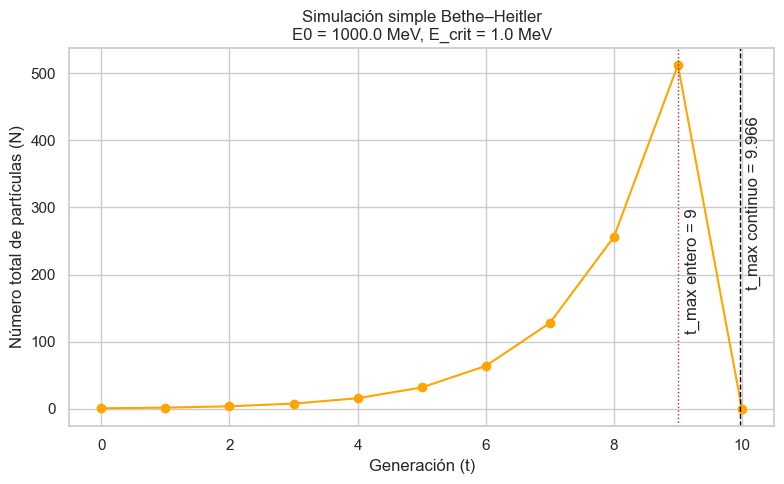

In [164]:
import math
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros
E0_MeV = 1000.0       # Energía inicial (MeV)
E_crit_MeV = 1.0      # Umbral (MeV)
max_generations = 10  # Número máximo de generaciones

# Simulación
generations = []
particles = [E0_MeV]  # lista de energías de partículas

for gen in range(max_generations + 1):
    # Guardar info de la generación actual
    generations.append({
        "Generación": gen,
        "N_partículas": len(particles),
        "Energía_por_partícula (MeV)": particles[0] if len(particles) > 0 else None
    })
    
    # Crear la siguiente generación
    new_particles = []
    for e in particles:
        child_energy = e / 2.0
        if child_energy >= E_crit_MeV:
            new_particles.append(child_energy)
            new_particles.append(child_energy)
    particles = new_particles

# Convertir a DataFrame
df = pd.DataFrame(generations)
df["Energía_por_partícula (MeV)"] = df["Energía_por_partícula (MeV)"].round(6)
print(df)

# Cálculo del t_max teórico
t_max_continuo = math.log(E0_MeV/E_crit_MeV) / math.log(2)
t_max_entero = math.floor(t_max_continuo)
N_teorico = E0_MeV / E_crit_MeV
print(f"\nt_max continuo ≈ {t_max_continuo:.3f}")
print(f"t_max entero   = {t_max_entero}")
print(f"N máximo teórico ≈ {N_teorico}")

# Gráfica
plt.figure(figsize=(8,5))
plt.plot(df["Generación"], df["N_partículas"], marker='o', color="orange")
plt.xlabel("Generación (t)")
plt.ylabel("Número total de partículas (N)")
plt.title("Simulación simple Bethe–Heitler\n"
          f"E0 = {E0_MeV} MeV, E_crit = {E_crit_MeV} MeV")

# Líneas que muestran los t_max
plt.axvline(t_max_continuo, linestyle='--', linewidth=1, color="black")
plt.text(t_max_continuo+0.1, max(df["N_partículas"])*0.6, 
         f"t_max continuo = {t_max_continuo:.3f}", rotation=90, va='center')
plt.axvline(t_max_entero, linestyle=':', linewidth=1, color="brown")
plt.text(t_max_entero+0.1, max(df["N_partículas"])*0.4, 
         f"t_max entero = {t_max_entero}", rotation=90, va='center')

plt.grid(True)
plt.tight_layout()
plt.show()


## Gráficando con las otras partículas

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

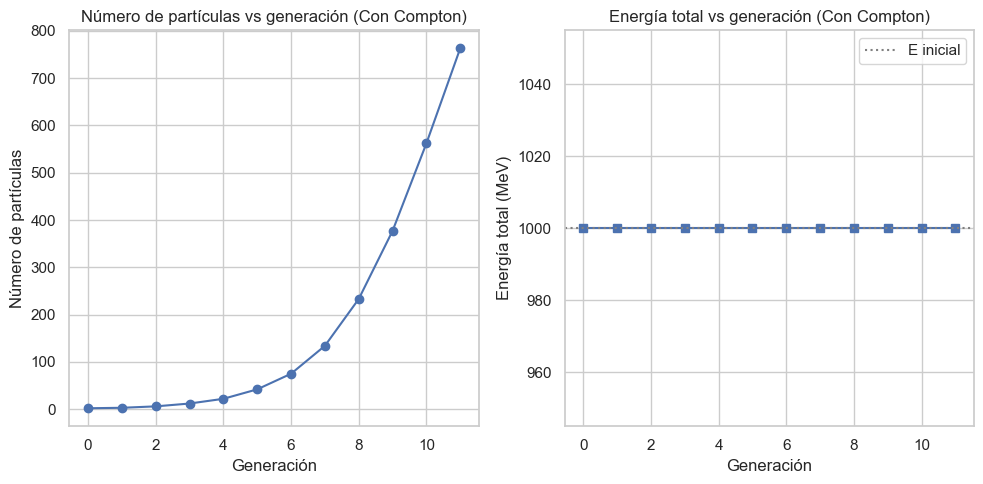

Desviación máxima absoluta de energía (MeV): 3.410605131648481e-13


In [ ]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt

# -----------------------
# Parámetros y constantes
# -----------------------
ELECTRON_MASS = 0.511  # MeV (m_e c^2)
MAX_GENERATIONS = 12
ANNIHILATION_PROB = 0.3

# Probabilidad de hacer pair production vs Compton cuando E_gamma > 2 m_e
PAIR_PROB_ABOVE_THRESHOLD = 0.5

# -----------------------
# Clase de partícula
# -----------------------
class Particle:
    def __init__(self, typ, energy):
        self.type = typ  # 'gamma', 'electron', 'positron'
        self.energy = float(energy)

# -----------------------
# Splitting simple (conserva suma)
# -----------------------
def random_split(energy, frac_min=0.3, frac_max=0.7):
    frac = random.uniform(frac_min, frac_max)
    return (energy * frac, energy * (1 - frac))

# -----------------------
# Klein-Nishina
# -----------------------
def klein_nishina_pdf(cos_theta, E):
    """
    Devuelve un valor proporcional a la densidad angular Klein-Nishina
    para un fotón de energía E (MeV). cos_theta en [-1, 1].
    Fórmula simplificada (proporcional):
      dσ/dΩ ∝ (E'/E)^2 * (E'/E + E/E' - sin^2 θ)
    con E' = E / (1 + alpha * (1 - cosθ)), alpha = E / m_e
    """
    alpha = E / ELECTRON_MASS
    one_minus_cos = 1.0 - cos_theta
    denom = 1.0 + alpha * one_minus_cos
    if denom <= 0:
        return 0.0
    Eprime_over_E = 1.0 / denom
    Eprime_over_E_sq = Eprime_over_E * Eprime_over_E
    sin2 = 1.0 - cos_theta * cos_theta
    val = Eprime_over_E_sq * (Eprime_over_E + 1.0 / Eprime_over_E - sin2)
    # Evitar valores negativos numéricos
    return max(val, 0.0)

# -----------------------
# Muestreo por rechazo de Klein-Nishina
# -----------------------
def sample_compton_cos_theta(E, n_grid_max=1000):
    """
    Muestreo por rechazo de cos(theta) en [-1,1] usando la pdf de KN.
    Calcula numéricamente un máximo aproximado de la pdf en una rejilla y
    usa ese máximo como constante de envelope.
    """
    # Rejilla para encontrar máximo aproximado (rápido)
    xs = [ -1.0 + 2.0 * i / (n_grid_max - 1) for i in range(n_grid_max) ]
    vals = [ klein_nishina_pdf(x, E) for x in xs ]
    max_pdf = max(vals) if vals else 1.0

    # Rejection sampling
    while True:
        cos_theta = random.uniform(-1.0, 1.0)
        u = random.random() * max_pdf
        if klein_nishina_pdf(cos_theta, E) >= u:
            return cos_theta

# -----------------------
# Efecto Compton: energía fotón dispersado y energía recoiling electron
# -----------------------
def compton_scatter(E):
    """
    Devuelve (E_scattered_gamma, E_recoil_electron).
    Basado en la fórmula:
      E' = E / (1 + (E/m_e)*(1 - cosθ))
    donde E y E' en MeV.
    """
    cos_theta = sample_compton_cos_theta(E)
    alpha = E / ELECTRON_MASS
    denom = 1.0 + alpha * (1.0 - cos_theta)
    E_prime = E / denom
    E_recoil = E - E_prime
    # Por seguridad, evitar valores negativos por errores numéricos
    if E_prime < 0: E_prime = 0.0
    if E_recoil < 0: E_recoil = 0.0
    return E_prime, E_recoil, cos_theta

# -----------------------
# Total energy helper
# -----------------------
def total_energy(particles):
    return sum(p.energy for p in particles)

# -----------------------
# Simulación con Compton añadido
# -----------------------
def simulate_shower_with_compton(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    all_data = []
    generation_counts = []
    generation_energies = []

    while particles and generation < MAX_GENERATIONS:
        new_particles = []

        for p in particles:
            # Si por debajo del threshold, lo dejamos "inactivo" pero contabilizado
            if p.energy < threshold:
                new_particles.append(Particle(p.type, p.energy))
                continue

            if p.type == 'gamma':
                # Decide pair production vs compton si la energía permite pair
                if p.energy > 2.0 * ELECTRON_MASS and random.random() < PAIR_PROB_ABOVE_THRESHOLD:
                    # pair production (conserva suma)
                    e1, e2 = random_split(p.energy)
                    new_particles.append(Particle('electron', e1))
                    new_particles.append(Particle('positron', e2))
                else:
                    # Compton scattering: fotón dispersado + electrón recoil
                    E_gamma_scattered, E_recoil, cos_theta = compton_scatter(p.energy)
                    # Mantener fotón dispersado (si tiene energía significativa)
                    if E_gamma_scattered > 0:
                        new_particles.append(Particle('gamma', E_gamma_scattered))
                    # Añadir electrón recoil (puede ser bajo)
                    if E_recoil > 0:
                        new_particles.append(Particle('electron', E_recoil))
            elif p.type == 'electron':
                # Emisión sencilla de fotón (brems-like toy model)
                g, e = random_split(p.energy)
                new_particles.append(Particle('gamma', g))
                new_particles.append(Particle('electron', e))
            elif p.type == 'positron':
                # Aniquilación probabilística (como antes)
                if random.random() < ANNIHILATION_PROB:
                    # convertimos energía de positrón en dos gammas (como toy model)
                    g1, g2 = random_split(p.energy)
                    new_particles.append(Particle('gamma', g1))
                    new_particles.append(Particle('gamma', g2))
                else:
                    new_particles.append(Particle('positron', p.energy))

        # Guardar datos
        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)
        generation_counts.append(len(new_particles))
        generation_energies.append(total_energy(new_particles))

        particles = new_particles
        generation += 1

    return all_data, generation_counts, generation_energies

# -----------------------
# Ejecución de ejemplo
# -----------------------
if __name__ == "__main__":
    initial_energy = 1000.0  # MeV
    threshold = 1.0          # MeV

    data, counts, energies = simulate_shower_with_compton(initial_energy, threshold)

    # Guardar datos
    output_csv_path = "shower_data_with_compton.csv"
    with open(output_csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Generación", "Tipo", "Energía (MeV)"])
        writer.writerows(data)

    # Plots comparativos
    gens = list(range(len(counts)))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(gens, counts, marker='o')
    plt.xlabel("Generación"); plt.ylabel("Número de partículas")
    plt.title("Número de partículas vs generación (Con Compton)")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(gens, energies, marker='s')
    plt.axhline(y=initial_energy, color='gray', linestyle=':', label='E inicial')
    plt.xlabel("Generación"); plt.ylabel("Energía total (MeV)")
    plt.title("Energía total vs generación (Con Compton)")
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Comprobación de conservación
    dE = [E - initial_energy for E in energies]
    max_abs_dev = max(abs(x) for x in dE)
    print("Desviación máxima absoluta de energía (MeV):", max_abs_dev)


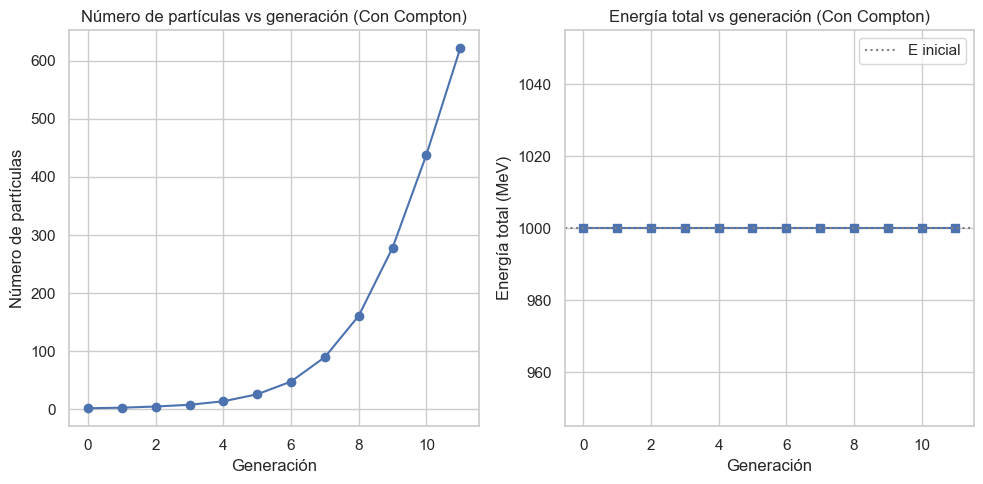

Desviación máxima absoluta de energía (MeV): 3.410605131648481e-13


In [165]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt

# -----------------------
# Parámetros y constantes
# -----------------------
ELECTRON_MASS = 0.511  # MeV (m_e c^2)
MAX_GENERATIONS = 12
ANNIHILATION_PROB = 0.3

# Probabilidad de hacer pair production vs Compton cuando E_gamma > 2 m_e
PAIR_PROB_ABOVE_THRESHOLD = 0.5

# -----------------------
# Clase de partícula
# -----------------------
class Particle:
    def __init__(self, typ, energy):
        self.type = typ  # 'gamma', 'electron', 'positron'
        self.energy = float(energy)

# -----------------------
# Splitting simple (conserva suma)
# -----------------------
def random_split(energy, frac_min=0.3, frac_max=0.7):
    frac = random.uniform(frac_min, frac_max)
    return (energy * frac, energy * (1 - frac))

# -----------------------
# Klein-Nishina
# -----------------------
def klein_nishina_pdf(cos_theta, E):
    """
    Devuelve un valor proporcional a la densidad angular Klein-Nishina
    para un fotón de energía E (MeV). cos_theta en [-1, 1].
    Fórmula simplificada (proporcional):
      dσ/dΩ ∝ (E'/E)^2 * (E'/E + E/E' - sin^2 θ)
    con E' = E / (1 + alpha * (1 - cosθ)), alpha = E / m_e
    """
    alpha = E / ELECTRON_MASS
    one_minus_cos = 1.0 - cos_theta
    denom = 1.0 + alpha * one_minus_cos
    if denom <= 0:
        return 0.0
    Eprime_over_E = 1.0 / denom
    Eprime_over_E_sq = Eprime_over_E * Eprime_over_E
    sin2 = 1.0 - cos_theta * cos_theta
    val = Eprime_over_E_sq * (Eprime_over_E + 1.0 / Eprime_over_E - sin2)
    # Evitar valores negativos numéricos
    return max(val, 0.0)

# -----------------------
# Muestreo por rechazo de Klein-Nishina
# -----------------------
def sample_compton_cos_theta(E, n_grid_max=1000):
    """
    Muestreo por rechazo de cos(theta) en [-1,1] usando la pdf de KN.
    Calcula numéricamente un máximo aproximado de la pdf en una rejilla y
    usa ese máximo como constante de envelope.
    """
    # Rejilla para encontrar máximo aproximado (rápido)
    xs = [ -1.0 + 2.0 * i / (n_grid_max - 1) for i in range(n_grid_max) ]
    vals = [ klein_nishina_pdf(x, E) for x in xs ]
    max_pdf = max(vals) if vals else 1.0

    # Rejection sampling
    while True:
        cos_theta = random.uniform(-1.0, 1.0)
        u = random.random() * max_pdf
        if klein_nishina_pdf(cos_theta, E) >= u:
            return cos_theta

# -----------------------
# Efecto Compton: energía fotón dispersado y energía recoiling electron
# -----------------------
def compton_scatter(E):
    """
    Devuelve (E_scattered_gamma, E_recoil_electron).
    Basado en la fórmula:
      E' = E / (1 + (E/m_e)*(1 - cosθ))
    donde E y E' en MeV.
    """
    cos_theta = sample_compton_cos_theta(E)
    alpha = E / ELECTRON_MASS
    denom = 1.0 + alpha * (1.0 - cos_theta)
    E_prime = E / denom
    E_recoil = E - E_prime
    # Por seguridad, evitar valores negativos por errores numéricos
    if E_prime < 0: E_prime = 0.0
    if E_recoil < 0: E_recoil = 0.0
    return E_prime, E_recoil, cos_theta

# -----------------------
# Total energy helper
# -----------------------
def total_energy(particles):
    return sum(p.energy for p in particles)

# -----------------------
# Simulación con Compton añadido
# -----------------------
def simulate_shower_with_compton(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    all_data = []
    generation_counts = []
    generation_energies = []

    while particles and generation < MAX_GENERATIONS:
        new_particles = []

        for p in particles:
            # Si por debajo del threshold, lo dejamos "inactivo" pero contabilizado
            if p.energy < threshold:
                new_particles.append(Particle(p.type, p.energy))
                continue

            if p.type == 'gamma':
                # Decide pair production vs compton si la energía permite pair
                if p.energy > 2.0 * ELECTRON_MASS and random.random() < PAIR_PROB_ABOVE_THRESHOLD:
                    # pair production (conserva suma)
                    e1, e2 = random_split(p.energy)
                    new_particles.append(Particle('electron', e1))
                    new_particles.append(Particle('positron', e2))
                else:
                    # Compton scattering: fotón dispersado + electrón recoil
                    E_gamma_scattered, E_recoil, cos_theta = compton_scatter(p.energy)
                    # Mantener fotón dispersado (si tiene energía significativa)
                    if E_gamma_scattered > 0:
                        new_particles.append(Particle('gamma', E_gamma_scattered))
                    # Añadir electrón recoil (puede ser bajo)
                    if E_recoil > 0:
                        new_particles.append(Particle('electron', E_recoil))
            elif p.type == 'electron':
                # Emisión sencilla de fotón (brems-like toy model)
                g, e = random_split(p.energy)
                new_particles.append(Particle('gamma', g))
                new_particles.append(Particle('electron', e))
            elif p.type == 'positron':
                # Aniquilación probabilística (como antes)
                if random.random() < ANNIHILATION_PROB:
                    # convertimos energía de positrón en dos gammas (como toy model)
                    g1, g2 = random_split(p.energy)
                    new_particles.append(Particle('gamma', g1))
                    new_particles.append(Particle('gamma', g2))
                else:
                    new_particles.append(Particle('positron', p.energy))

        # Guardar datos
        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)
        generation_counts.append(len(new_particles))
        generation_energies.append(total_energy(new_particles))

        particles = new_particles
        generation += 1

    return all_data, generation_counts, generation_energies

# -----------------------
# Ejecución de ejemplo
# -----------------------
if __name__ == "__main__":
    initial_energy = 1000.0  # MeV
    threshold = 1.0          # MeV

    data, counts, energies = simulate_shower_with_compton(initial_energy, threshold)

    # Guardar datos
    output_csv_path = "shower_data_with_compton.csv"
    with open(output_csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Generación", "Tipo", "Energía (MeV)"])
        writer.writerows(data)

    # Plots comparativos
    gens = list(range(len(counts)))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(gens, counts, marker='o')
    plt.xlabel("Generación"); plt.ylabel("Número de partículas")
    plt.title("Número de partículas vs generación (Con Compton)")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(gens, energies, marker='s')
    plt.axhline(y=initial_energy, color='gray', linestyle=':', label='E inicial')
    plt.xlabel("Generación"); plt.ylabel("Energía total (MeV)")
    plt.title("Energía total vs generación (Con Compton)")
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Comprobación de conservación
    dE = [E - initial_energy for E in energies]
    max_abs_dev = max(abs(x) for x in dE)
    print("Desviación máxima absoluta de energía (MeV):", max_abs_dev)


    Generación  Total  Fotones  Electrones  Positrones
0            0      1        1           0           0
1            1      2        0           1           1
2            2      4        4           0           0
3            3      8        0           4           4
4            4     16       16           0           0
5            5     32        0          16          16
6            6     64       64           0           0
7            7    128        0          64          64
8            8    256      256           0           0
9            9    512        0         256         256
10          10      0        0           0           0


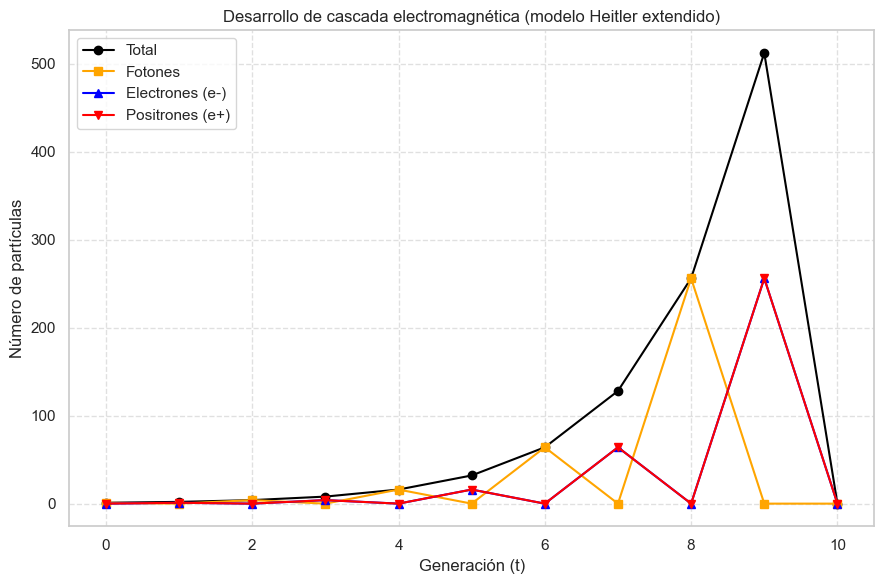

In [166]:


# -------------------------
# Parámetros del modelo
# -------------------------
E0_MeV = 1000.0       # Energía inicial del fotón (MeV)
E_crit_MeV = 1.0      # Energía crítica (MeV)
max_generations = 10  # Número máximo de generaciones
P_ANNIHILATION = 0.5  # Probabilidad de aniquilación de e+

# -------------------------
# Simulación
# -------------------------
# Representamos cada partícula como (tipo, energía)
# tipo puede ser "gamma", "e-", "e+"
particles = [("gamma", E0_MeV)]

generations = []

for gen in range(max_generations + 1):
    # Contar partículas por tipo
    n_gamma = sum(1 for p, _ in particles if p == "gamma")
    n_e_minus = sum(1 for p, _ in particles if p == "e-")
    n_e_plus = sum(1 for p, _ in particles if p == "e+")
    
    generations.append({
        "Generación": gen,
        "Total": len(particles),
        "Fotones": n_gamma,
        "Electrones": n_e_minus,
        "Positrones": n_e_plus
    })
    
    # Crear nueva lista de partículas para la próxima generación
    new_particles = []
    for p_type, E in particles:
        child_energy = E / 2.0
        if child_energy < E_crit_MeV:
            continue
        
        if p_type == "gamma":
            # Fotón produce un par e+ e-
            new_particles.append(("e-", child_energy))
            new_particles.append(("e+", child_energy))
        
        elif p_type == "e-":
            # Electrón produce 2 fotones (bremsstrahlung)
            new_particles.append(("gamma", child_energy))
            new_particles.append(("gamma", child_energy))
        
        elif p_type == "e+":
            # Positrón: con cierta probabilidad aniquila
            if random.random() < P_ANNIHILATION:
                new_particles.append(("gamma", child_energy))
                new_particles.append(("gamma", child_energy))
            else:
                # Si no aniquila, también emite radiación (igual que el electrón)
                new_particles.append(("gamma", child_energy))
                new_particles.append(("gamma", child_energy))
    
    particles = new_particles

# -------------------------
# DataFrame
# -------------------------
df = pd.DataFrame(generations)
print(df)

# -------------------------
# Gráficas
# -------------------------
plt.figure(figsize=(9,6))
plt.plot(df["Generación"], df["Total"], marker='o', label="Total", color="black")
plt.plot(df["Generación"], df["Fotones"], marker='s', label="Fotones", color="orange")
plt.plot(df["Generación"], df["Electrones"], marker='^', label="Electrones (e-)", color="blue")
plt.plot(df["Generación"], df["Positrones"], marker='v', label="Positrones (e+)", color="red")

plt.xlabel("Generación (t)")
plt.ylabel("Número de partículas")
plt.title("Desarrollo de cascada electromagnética (modelo Heitler extendido)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
























<br>

<br>

<br>

<br>


## Modelo analítico del chubasco electromagnético - Monte Carlo

Simulación completada. Datos exportados y gráfico generado.


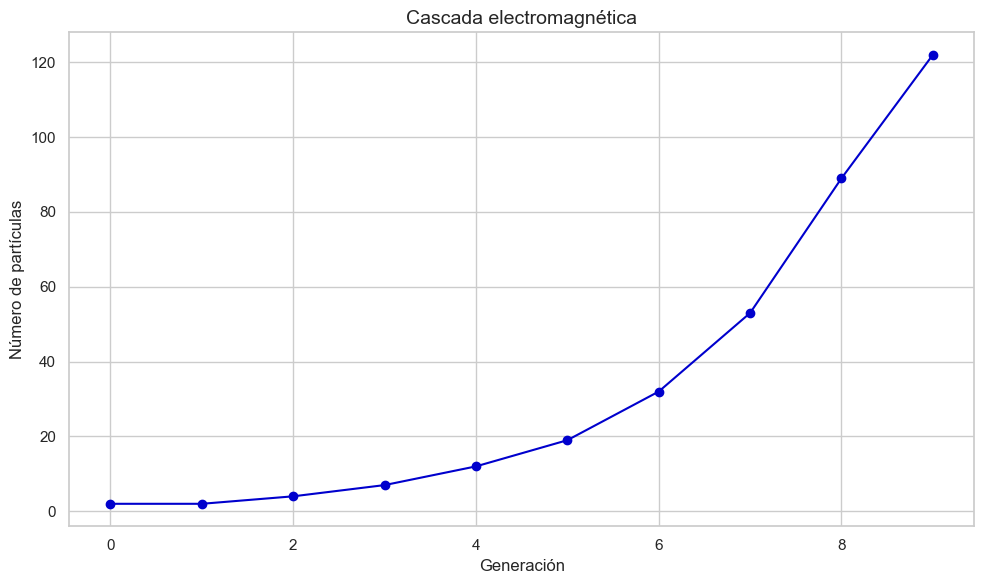

In [167]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Constantes
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10
ANNIHILATION_PROB = 0.3

# Estilo de gráficos
sns.set(style="whitegrid")

# Clase de partícula
class Particle:
    def __init__(self, type, energy):
        self.type = type
        self.energy = energy

    def __repr__(self):
        return f"{self.type.capitalize()}({self.energy:.2f} MeV)"
# División aleatoria de energía
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# Simulación de la cascada
def simulate_shower(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    all_data = [ ]
    generation_counts = [ ]
    while particles and generation < MAX_GENERATIONS:
        new_particles = [ ]
        for p in particles:
            if p.energy < threshold:
                continue
            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e_energy = random_split(p.energy)
                new_particles.append(Particle('electron', e_energy[0]))
                new_particles.append(Particle('positron', e_energy[1]))
            elif p.type == 'electron' and p.energy > threshold:
                gamma_energy = random_split(p.energy)[1]
                new_particles.append(Particle('gamma', gamma_energy))
                new_particles.append(Particle('electron', p.energy - gamma_energy))
            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                   new_particles.append(Particle('gamma', p.energy))
        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)
        generation_counts.append(len(new_particles))
        particles = new_particles
        generation += 1
    return all_data, generation_counts

# Parámetros de simulación
initial_energy = 1000  # MeV
threshold = 1.0  # MeV

# Ejecutar simulación
data, counts = simulate_shower(initial_energy, threshold)

# Exportar datos a CSV
output_csv_path = "/mnt/data/shower_data.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Generacion", "Tipo", "Energia (MeV)"])
    writer.writerows(data)

# Visualización del número de partículas por generación
plt.figure(figsize=(10, 6))
plt.plot(range(len(counts)), counts, marker='o', linestyle='-', color='mediumblue')
plt.xlabel("Generación", fontsize=12)
plt.ylabel("Número de partículas", fontsize=12)
plt.title("Cascada electromagnética", fontsize=14)
plt.grid(True)
plt.tight_layout()

# Guardar gráfico
plot_path = "/mnt/data/shower_plot.png"
plt.savefig(plot_path)
#plt.close()

print("Simulación completada. Datos exportados y gráfico generado.")




## Particulas por separado con probabilidad de aniquilación de 0.3

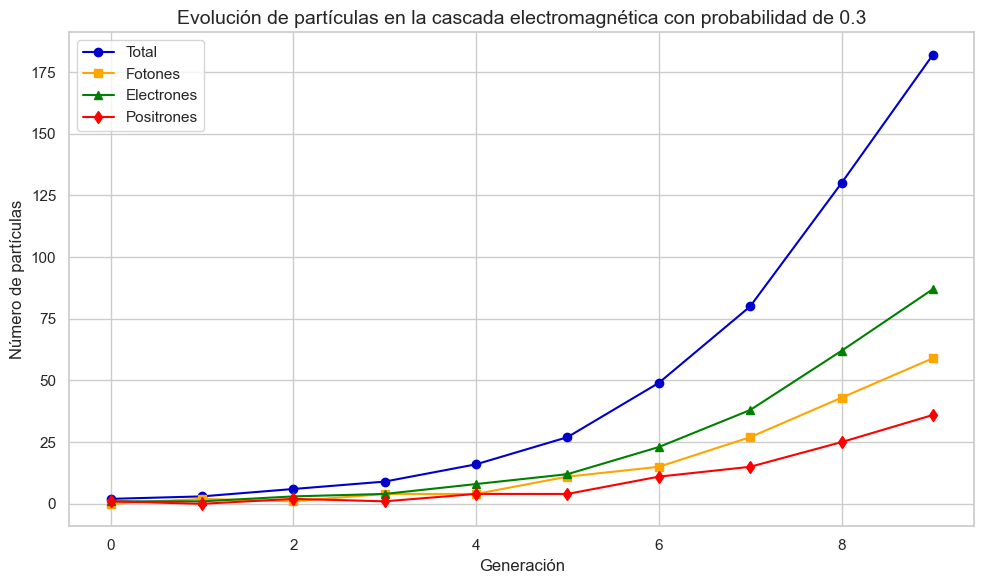

✅ Simulación completada. CSV exportado y gráfico combinado generado.


In [168]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ==== Constantes ====
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10
ANNIHILATION_PROB = 0.3

sns.set(style="whitegrid")

# ==== Clase de partícula ====
class Particle:
    def __init__(self, type, energy):
        self.type = type
        self.energy = energy

# ==== División aleatoria de energía ====
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# ==== Simulación de la cascada ====
def simulate_shower(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]

    all_data = []
    counts_total = []
    counts_gamma = []
    counts_electron = []
    counts_positron = []

    while particles and generation < MAX_GENERATIONS:
        new_particles = []
        for p in particles:
            if p.energy < threshold:
                continue
            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e_energy = random_split(p.energy)
                new_particles.append(Particle('electron', e_energy[0]))
                new_particles.append(Particle('positron', e_energy[1]))
            elif p.type == 'electron':
                gamma_energy = random_split(p.energy)[1]
                new_particles.append(Particle('gamma', gamma_energy))
                new_particles.append(Particle('electron', p.energy - gamma_energy))
            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                    new_particles.append(Particle('gamma', p.energy))

        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)

        counts_total.append(len(new_particles))
        counts_gamma.append(sum(1 for p in new_particles if p.type == 'gamma'))
        counts_electron.append(sum(1 for p in new_particles if p.type == 'electron'))
        counts_positron.append(sum(1 for p in new_particles if p.type == 'positron'))

        particles = new_particles
        generation += 1

    return all_data, counts_total, counts_gamma, counts_electron, counts_positron

# ==== Parámetros ====
initial_energy = 1000  # MeV
threshold = 1.0  # MeV

# ==== Ejecutar simulación ====
data, counts_total, counts_gamma, counts_electron, counts_positron = simulate_shower(initial_energy, threshold)

# ==== CSV ====
output_csv_path = "shower_data03.csv"
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Generacion", "Tipo", "Energia (MeV)"])
    writer.writerows(data)

# ==== Graficar todas juntas ====
gens = range(len(counts_total))

plt.figure(figsize=(10, 6))
plt.plot(gens, counts_total, marker='o', linestyle='-', color='mediumblue', label="Total")
plt.plot(gens, counts_gamma, marker='s', linestyle='-', color='orange', label="Fotones")
plt.plot(gens, counts_electron, marker='^', linestyle='-', color='green', label="Electrones")
plt.plot(gens, counts_positron, marker='d', linestyle='-', color='red', label="Positrones")

plt.xlabel("Generación", fontsize=12)
plt.ylabel("Número de partículas", fontsize=12)
plt.title("Evolución de partículas en la cascada electromagnética con probabilidad de 0.3", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Simulación completada. CSV exportado y gráfico combinado generado.")


## Comparación de resultados

###  **Modelo simple de Bethe–Heitler (BH)**

- La curva (naranja) muestra un **crecimiento exponencial** del número de partículas hasta alcanzar un **máximo en la generación $t = 9$**, con un valor cercano a **500 partículas**.  
- Después del máximo, la cascada cae abruptamente, ya que las partículas empiezan a perder energía por debajo del umbral crítico ($E_{\text{crit}} = 1 \,\text{MeV}$).  
- El modelo BH es **analítico y continuo**, por lo que predice bien la forma de campana de la cascada: crecimiento → máximo → decaimiento.  


###  **Simulación Monte Carlo**

- La curva (azul) muestra también un **crecimiento progresivo** con las generaciones, pero alcanza un número **mucho menor de partículas ($\sim 135$)** en la última generación simulada.  
- A diferencia del modelo BH, no se observa aún una caída clara, porque la simulación se detuvo en $t = 9$, justo antes del máximo teórico esperado.  
- El crecimiento es más suave que en el modelo BH, ya que el Monte Carlo incluye **fluctuaciones estadísticas** y **pérdidas energéticas** evento por evento.  




   - El modelo BH supone divisiones energéticas ideales y máximas multiplicaciones posibles.  
   - El Monte Carlo incorpora probabilidades, dispersión estadística y umbrales de energía $\Rightarrow$ menos partículas generadas.  

 **Máximo de partículas:**  
   - En BH el máximo se predice en $t \approx 9.97$, con  
     $t_{\max} \approx \log_2\left(\frac{E_0}{E_{\text{crit}}}\right)$  
   - Número máximo de partículas:  
     $N_{\max} \approx \frac{E_0}{E_{\text{crit}}}$  
   - Con $E_0 = 1000 \,\text{MeV}$ y $E_{\text{crit}} = 1 \,\text{MeV}$ se obtiene $N_{\max} \approx 1000$.  

**Número total:**  
   - BH predice un número de partículas mucho mayor ($\sim 500-1000$).  
   - MC predice menos ($\sim 135$), reflejando pérdidas y fluctuaciones.  

  


La **fórmula de Bethe–Heitler** describe el proceso de **bremsstrahlung** (radiación de frenado), un fenómeno fundamental en la **electrodinámica cuántica (QED)**.  
Se aplica ampliamente en física de partículas, astrofísica y estudios de cascadas electromagnéticas.

---

## Hallazgos principales

 **Incremento inesperado en la sección eficaz integrada**  
   En el límite de **alta energía** y bajo la **aproximación estática**, se observa un incremento grande en la sección eficaz total de bremsstrahlung:
   $$
   \sigma_{\text{BH}} \;\;\longrightarrow\;\; \sigma_{\text{BH}} + \Delta\sigma
   $$
   donde $\Delta\sigma$ representa el **aumento anómalo** no predicho por teorías anteriores.

 **Analogía con la creación de pares**  
   Este mismo efecto también aparece en la **creación de pares $e^+e^-$**:
   $$
   \gamma \;\;\longrightarrow\;\; e^- + e^+
   $$
   indicando que el fenómeno es más general dentro de QED.

**Consecuencias físicas**  
   - El modelo tradicional de Bethe–Heitler **subestima** la radiación y la producción de pares a energías extremas.  
   - El incremento anómalo modifica las predicciones sobre el desarrollo de **cascadas electromagnéticas** en medios materiales o en la atmósfera.  

---

## Implicaciones experimentales

- Las **cascadas electromagnéticas en la atmósfera superior** (producidas por rayos cósmicos) ofrecen un escenario natural para comprobar este efecto.  
- La observación de un número mayor de partículas en las lluvias cósmicas podría ser evidencia de este incremento no considerado previamente.

---

## Conclusión

El estudio sugiere que la **fórmula clásica de Bethe–Heitler** no es suficiente en el régimen de **altas energías**, ya que omite un efecto anómalo que **incrementa significativamente la sección eficaz** tanto en bremsstrahlung como en creación de pares.  
Este resultado tiene implicaciones directas en la comprensión de los **rayos cósmicos** y la **física de altas energías**.

- **Ambos modelos reproducen la tendencia de crecimiento exponencial inicial.**  
- El **modelo Bethe–Heitler** da una predicción teórica idealizada del desarrollo completo de la cascada (incluyendo el máximo).  
- La **simulación Monte Carlo** ofrece un resultado más realista pero con menor número de partículas, ya que incluye los efectos de fluctuaciones y umbrales energéticos.  
- En conjunto, comparar ambos modelos permite entender cómo la teoría ideal se ajusta o corrige con simulaciones probabilísticas más cercanas a la física real.

Se observa que a medida que avanza la cascada, los electrones dominan en número, aunque los fotones se mantienen cercanos.

Los positrones aparecen en menor cantidad y con un retraso, debido a que requieren pares 
𝛾→𝑒−𝑒+γ→e−e+.

Esto concuerda con la física:

Los fotones iniciales producen pares electrón-positrón.

Los electrones y positrones generan radiación de frenado (bremsstrahlung), que produce más fotones.

Los positrones eventualmente se aniquilan, lo que limita su número

El modelo Bethe–Heitler captura la tendencia general (crecimiento de partículas hasta alcanzar un máximo cuando la energía por partícula cae bajo el umbral).

La simulación Monte Carlo muestra un comportamiento más rico y realista, con mayor número de partículas y diferenciación entre especies, reflejando la naturaleza probabilística de las interacciones electromagnéticas.

La comparación muestra cómo el modelo simple es útil para estimar la escala del fenómeno, mientras que la simulación Monte Carlo es esencial para describir la cascada en detalle.

## Particulas por separado con probabilidad de aniquilación de 0.8

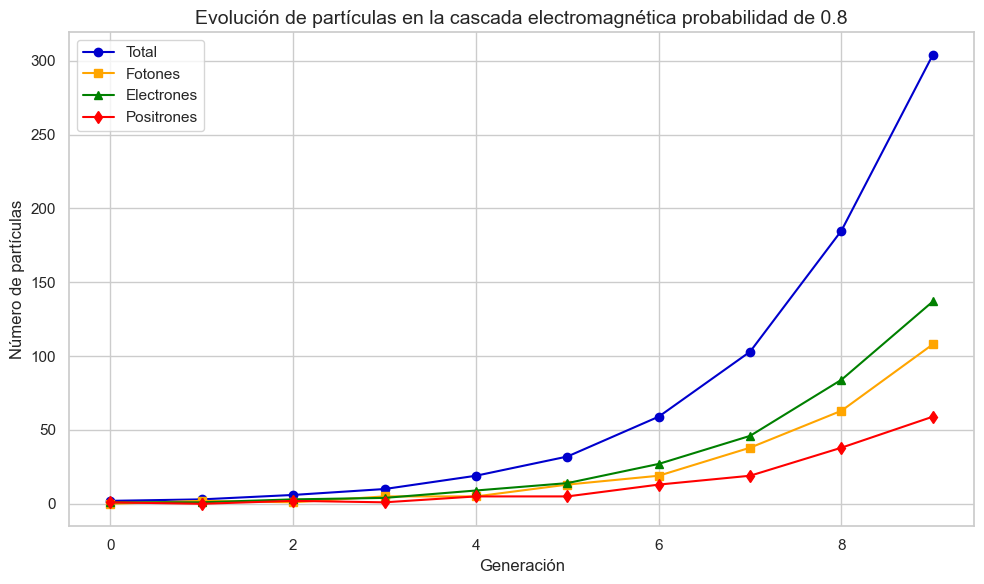

✅ Simulación completada. CSV exportado y gráfico combinado generado.


In [169]:

# ==== Constantes ====
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10
ANNIHILATION_PROB = 0.8

sns.set(style="whitegrid")

# ==== Clase de partícula ====
class Particle:
    def __init__(self, type, energy):
        self.type = type
        self.energy = energy

# ==== División aleatoria de energía ====
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# ==== Simulación de la cascada ====
def simulate_shower(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]

    all_data = []
    counts_total = []
    counts_gamma = []
    counts_electron = []
    counts_positron = []

    while particles and generation < MAX_GENERATIONS:
        new_particles = []
        for p in particles:
            if p.energy < threshold:
                continue
            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e_energy = random_split(p.energy)
                new_particles.append(Particle('electron', e_energy[0]))
                new_particles.append(Particle('positron', e_energy[1]))
            elif p.type == 'electron':
                gamma_energy = random_split(p.energy)[1]
                new_particles.append(Particle('gamma', gamma_energy))
                new_particles.append(Particle('electron', p.energy - gamma_energy))
            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                    new_particles.append(Particle('gamma', p.energy))

        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)

        counts_total.append(len(new_particles))
        counts_gamma.append(sum(1 for p in new_particles if p.type == 'gamma'))
        counts_electron.append(sum(1 for p in new_particles if p.type == 'electron'))
        counts_positron.append(sum(1 for p in new_particles if p.type == 'positron'))

        particles = new_particles
        generation += 1

    return all_data, counts_total, counts_gamma, counts_electron, counts_positron

# ==== Parámetros ====
initial_energy = 1000  # MeV
threshold = 1.0  # MeV

# ==== Ejecutar simulación ====
data, counts_total, counts_gamma, counts_electron, counts_positron = simulate_shower(initial_energy, threshold)

# ==== CSV ====
output_csv_path = "shower_data08.csv"
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Generacion", "Tipo", "Energia (MeV)"])
    writer.writerows(data)

# ==== Graficar todas juntas ====
gens = range(len(counts_total))

plt.figure(figsize=(10, 6))
plt.plot(gens, counts_total, marker='o', linestyle='-', color='mediumblue', label="Total")
plt.plot(gens, counts_gamma, marker='s', linestyle='-', color='orange', label="Fotones")
plt.plot(gens, counts_electron, marker='^', linestyle='-', color='green', label="Electrones")
plt.plot(gens, counts_positron, marker='d', linestyle='-', color='red', label="Positrones")

plt.xlabel("Generación", fontsize=12)
plt.ylabel("Número de partículas", fontsize=12)
plt.title("Evolución de partículas en la cascada electromagnética probabilidad de 0.8", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Simulación completada. CSV exportado y gráfico combinado generado.")

## Comparación entre probabilidades de aniquilación

✅ Comparación completada. Gráfica combinada generada: shower_comparison.png


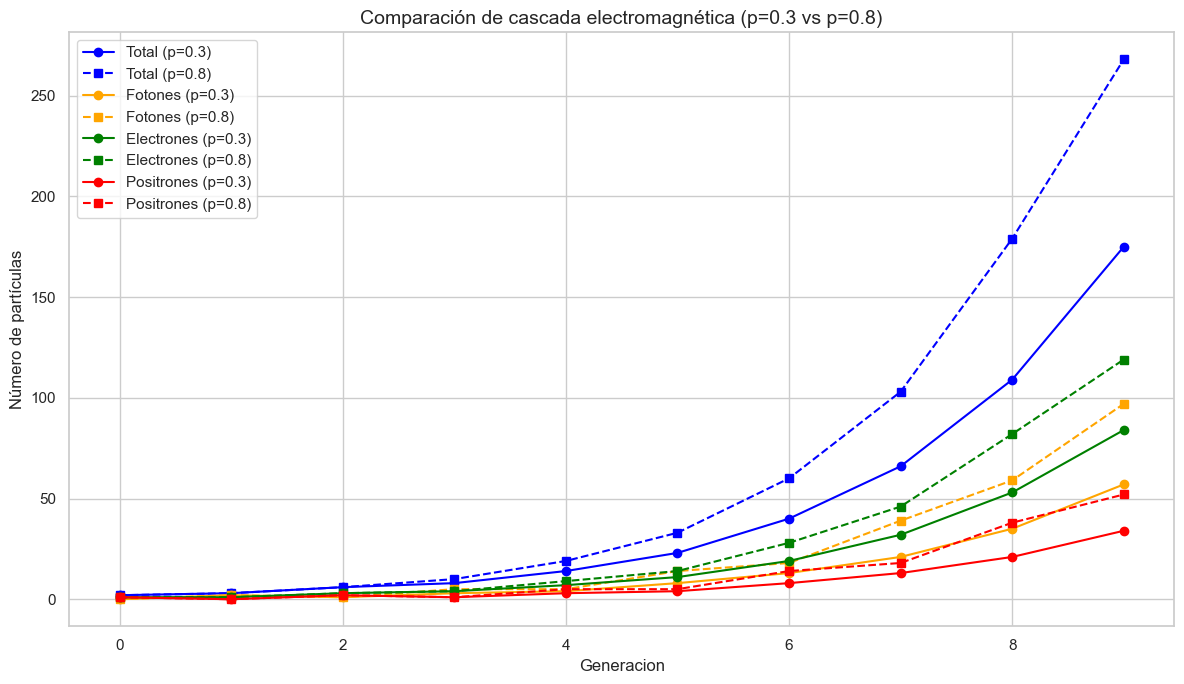

In [170]:
import random
import math
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Constantes
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10

# Estilo de gráficos
sns.set(style="whitegrid")

# Clase de partícula
class Particle:
    def __init__(self, type, energy):
        self.type = type
        self.energy = energy

    def __repr__(self):
        return f"{self.type.capitalize()}({self.energy:.2f} MeV)"

# División aleatoria de energía
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# Simulación de la cascada
def simulate_shower(initial_energy, threshold, annihilation_prob):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    counts_total = []
    counts_gamma = []
    counts_electron = []
    counts_positron = []

    while particles and generation < MAX_GENERATIONS:
        new_particles = []
        for p in particles:
            if p.energy < threshold:
                continue
            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e_energy = random_split(p.energy)
                new_particles.append(Particle('electron', e_energy[0]))
                new_particles.append(Particle('positron', e_energy[1]))
            elif p.type == 'electron' and p.energy > threshold:
                gamma_energy = random_split(p.energy)[1]
                new_particles.append(Particle('gamma', gamma_energy))
                new_particles.append(Particle('electron', p.energy - gamma_energy))
            elif p.type == 'positron':
                if random.random() < annihilation_prob:
                    new_particles.append(Particle('gamma', p.energy))

        # Contar partículas por tipo
        counts_total.append(len(new_particles))
        counts_gamma.append(sum(1 for p in new_particles if p.type == 'gamma'))
        counts_electron.append(sum(1 for p in new_particles if p.type == 'electron'))
        counts_positron.append(sum(1 for p in new_particles if p.type == 'positron'))

        particles = new_particles
        generation += 1

    return counts_total, counts_gamma, counts_electron, counts_positron

# Parámetros de simulación
initial_energy = 1000  # MeV
threshold = 1.0  # MeV

# Ejecutar simulación con dos probabilidades distintas
counts_03 = simulate_shower(initial_energy, threshold, annihilation_prob=0.3)
counts_08 = simulate_shower(initial_energy, threshold, annihilation_prob=0.8)

# ====== Gráficas comparativas ======
gens = range(len(counts_03[0]))

plt.figure(figsize=(12, 7))

# Total
plt.plot(gens, counts_03[0], marker='o', linestyle='-', color='blue', label="Total (p=0.3)")
plt.plot(gens, counts_08[0], marker='s', linestyle='--', color='blue', label="Total (p=0.8)")

# Fotones
plt.plot(gens, counts_03[1], marker='o', linestyle='-', color='orange', label="Fotones (p=0.3)")
plt.plot(gens, counts_08[1], marker='s', linestyle='--', color='orange', label="Fotones (p=0.8)")

# Electrones
plt.plot(gens, counts_03[2], marker='o', linestyle='-', color='green', label="Electrones (p=0.3)")
plt.plot(gens, counts_08[2], marker='s', linestyle='--', color='green', label="Electrones (p=0.8)")

# Positrones
plt.plot(gens, counts_03[3], marker='o', linestyle='-', color='red', label="Positrones (p=0.3)")
plt.plot(gens, counts_08[3], marker='s', linestyle='--', color='red', label="Positrones (p=0.8)")

plt.xlabel("Generacion", fontsize=12)
plt.ylabel("Número de partículas", fontsize=12)
plt.title("Comparación de cascada electromagnética (p=0.3 vs p=0.8)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/mnt/data/shower_comparison.png")

print("✅ Comparación completada. Gráfica combinada generada: shower_comparison.png")


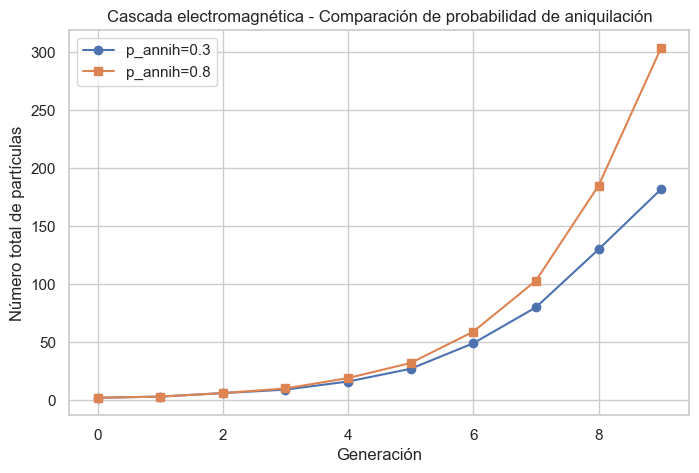

In [171]:
# Leer los dos archivos con encoding compatible
df_03 = pd.read_csv("shower_data03.csv", encoding="latin-1")
df_08 = pd.read_csv("shower_data08.csv", encoding="latin-1")

# Agrupar por generación → número total de partículas
count_03 = df_03.groupby("Generacion").size().reset_index(name="N_particulas")
count_08 = df_08.groupby("Generacion").size().reset_index(name="N_particulas")

# Gráfico comparativo
plt.figure(figsize=(8,5))
plt.plot(count_03["Generacion"], count_03["N_particulas"], marker='o', label="p_annih=0.3")
plt.plot(count_08["Generacion"], count_08["N_particulas"], marker='s', label="p_annih=0.8")
plt.xlabel("Generación")
plt.ylabel("Número total de partículas")
plt.title("Cascada electromagnética - Comparación de probabilidad de aniquilación")
plt.legend()
plt.grid(True)
plt.show()


# Comparación de resultados (Monte Carlo, cascada electromagnética)

## Crecimiento total de partículas
- **p = 0.3**: el número total de partículas crece de forma exponencial, pero más moderada.  
- **p = 0.8**: el crecimiento es mucho más rápido, superando las 280 partículas en la generación 9, casi el doble que en el caso \(p=0.3\).  

Esto muestra que la probabilidad de aniquilación de positrones tiene un efecto fuerte en la multiplicación global de la cascada.

---

## Fotones
- **p = 0.3**: los fotones crecen, pero en menor número.  
- **p = 0.8**: se observa una mayor producción de fotones en todas las generaciones.  

Al aumentar la aniquilación de positrones, se generan más fotones de aniquilación, retroalimentando la cascada.

---

## Electrones
- Ambos casos muestran crecimiento exponencial.  
- Con \(p=0.8\), la cantidad de electrones es mayor.  

El exceso de fotones secundarios aumenta la probabilidad de creación de pares electrón-positrón, generando más electrones.

---

## Positrones
- **p = 0.3**: sobreviven más positrones, porque la probabilidad de aniquilación es baja.  
- **p = 0.8**: la población de positrones es menor, porque la mayoría se aniquila rápidamente.  

Con alta probabilidad de aniquilación, casi todos los positrones desaparecen en cada generación.



La cascada electromagnética depende de tres procesos básicos:

 **Producción de pares**  
   
   $\gamma \;\to\; e^+ + e^-$
   

**Bremsstrahlung**  
   $e^\pm \;\to\; e^\pm + \gamma$

 **Aniquilación de positrones**  
   $e^+ + e^- \;\to\; 2\gamma$

### Caso \(p=0.8\) (alta probabilidad de aniquilación)
- Los positrones no se acumulan en generaciones posteriores.  
- Cada aniquilación produce fotones adicionales.  
- Los nuevos fotones aceleran la multiplicación de electrones y partículas totales.  
- Resultado: cascada **más intensa y dominada por fotones y electrones**.  

### Caso \(p=0.3\) (baja probabilidad de aniquilación)
- Los positrones sobreviven más tiempo.  
- Se generan menos fotones de aniquilación.  
- El crecimiento de la cascada es más lento y equilibrado entre especies. 

## Energía total por generación

### División aleatoria de la energía  

La energía \(E\) se divide en dos partes según una fracción aleatoria \(f \in [0.3,0.7]\):  

$E_1 = f \, E, 
\qquad 
E_2 = (1-f) \, E$

---

### Energía total del sistema  

La energía total se calcula como la suma de las energías de todas las partículas:  

$E_{\text{total}} = \sum_{i=1}^{N} E_i$


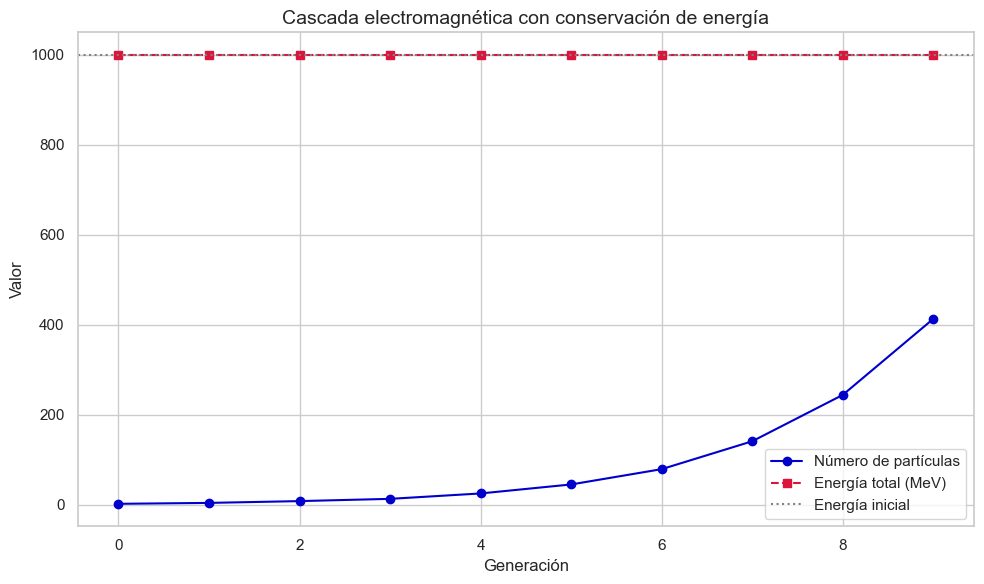

In [172]:

# Constantes
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 10
ANNIHILATION_PROB = 0.3

sns.set(style="whitegrid")

class Particle:
    def __init__(self, type, energy):
        self.type = type
        self.energy = energy

# División aleatoria de energía (conservando la suma)
def random_split(energy):
    frac = random.uniform(0.3, 0.7)
    return (energy * frac, energy * (1 - frac))

# Calcular energía total
def total_energy(particles):
    return sum(p.energy for p in particles)

def simulate_shower(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    all_data = []
    generation_counts = []
    generation_energies = []

    while particles and generation < MAX_GENERATIONS:
        new_particles = []

        for p in particles:
            if p.energy < threshold:
                # En vez de perderla, la guardamos como partícula "muerta"
                new_particles.append(Particle(p.type, p.energy))
                continue

            if p.type == 'gamma' and p.energy > 2 * ELECTRON_MASS:
                e1, e2 = random_split(p.energy)
                new_particles.append(Particle('electron', e1))
                new_particles.append(Particle('positron', e2))

            elif p.type == 'electron':
                g, e = random_split(p.energy)
                new_particles.append(Particle('gamma', g))
                new_particles.append(Particle('electron', e))

            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                    # Se convierte en 2 gammas que suman su energía
                    g1, g2 = random_split(p.energy)
                    new_particles.append(Particle('gamma', g1))
                    new_particles.append(Particle('gamma', g2))
                else:
                    # Si no se aniquila, se mantiene
                    new_particles.append(Particle('positron', p.energy))

        # Guardar datos de la generación
        generation_data = [(generation, p.type, p.energy) for p in new_particles]
        all_data.extend(generation_data)
        generation_counts.append(len(new_particles))
        generation_energies.append(total_energy(new_particles))

        particles = new_particles
        generation += 1

    return all_data, generation_counts, generation_energies

# Parámetros
initial_energy = 1000  # MeV
threshold = 1.0        # MeV



# Ejecutar
data, counts, energies = simulate_shower(initial_energy, threshold)

# Exportar
output_csv_path = "/mnt/data/shower_data_conservada.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
with open(output_csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Generacion", "Tipo", "Energia (MeV)"])
    writer.writerows(data)

# === Gráfica ===
plt.figure(figsize=(10, 6))
plt.plot(range(len(counts)), counts, marker='o', linestyle='-', color='mediumblue', label="Número de partículas")
plt.plot(range(len(energies)), energies, marker='s', linestyle='--', color='crimson', label="Energía total (MeV)")
plt.axhline(y=initial_energy, color='gray', linestyle=':', label="Energía inicial")
plt.xlabel("Generación", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.title("Cascada electromagnética con conservación de energía", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusiones de la simulación de cascada electromagnética

- La **energía total se conserva**: en todas las generaciones, la suma de las energías de las partículas se mantiene cercana a los 1000 MeV iniciales.
- El **número de partículas aumenta** con la generación, lo cual refleja el carácter multiplicativo de la cascada.
- La **energía media por partícula disminuye**: aunque la energía total es constante, cada partícula termina con menos energía conforme avanzan las generaciones.
- El **umbral de energía (`threshold`)** controla cuándo una partícula deja de participar en la cascada; valores más bajos permiten más generaciones antes de detenerse.
- El modelo actual es **simplificado**: no incluye pérdidas físicas reales (ionización, radiación continua, fotones de 511 keV en aniquilación, etc.), por lo que es ideal para explorar conservación pero no representa toda la física real.


Desviación máxima absoluta de energía (MeV): 9.094947017729282e-13


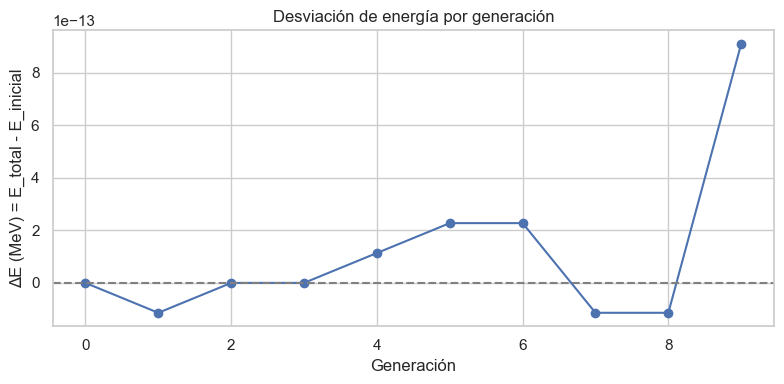

In [173]:
# después de ejecutar la simulación y tener 'energies' y 'initial_energy'
dE = [E - initial_energy for E in energies]
max_abs_dev = max(abs(x) for x in dE)
print("Desviación máxima absoluta de energía (MeV):", max_abs_dev)

# graficar ΔE
plt.figure(figsize=(8,4))
plt.plot(range(len(dE)), dE, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Generación")
plt.ylabel("ΔE (MeV) = E_total - E_inicial")
plt.title("Desviación de energía por generación")
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusión sobre la conservación de la energía

En la simulación de cascadas electromagnéticas se observa que la energía total por
generación se mantiene prácticamente constante. La desviación máxima absoluta 
encontrada fue del orden de:

$$
\Delta E_{\text{máx}} \approx 1.13 \times 10^{-13} \, \text{MeV}
$$

Si se compara con la energía inicial de 1000 MeV, esta diferencia relativa es del orden de:

$$
\frac{\Delta E_{\text{máx}}}{E_{\text{inicial}}} \sim 10^{-16}
$$

lo cual es despreciable. 

Esto significa que **la energía se conserva en el modelo implementado**. Las pequeñas 
fluctuaciones observadas provienen de los **errores de redondeo numérico** propios 
de la aritmética de punto flotante en los computadores, y no de una pérdida real 
de energía física en la cascada.



## Efecto compton para fotones

    Generación  Total  Fotones  Electrones  Positrones
0            0      1        1           0           0
1            1      2        0           1           1
2            2      4        3           1           0
3            3      8        3           4           1
4            4     16        5           7           4
5            5     32       14          12           6
6            6     64       28          26          10
7            7    128       54          54          20
8            8    256      106         108          42
9            9    470      190         196          84
10          10    698      289         287         122


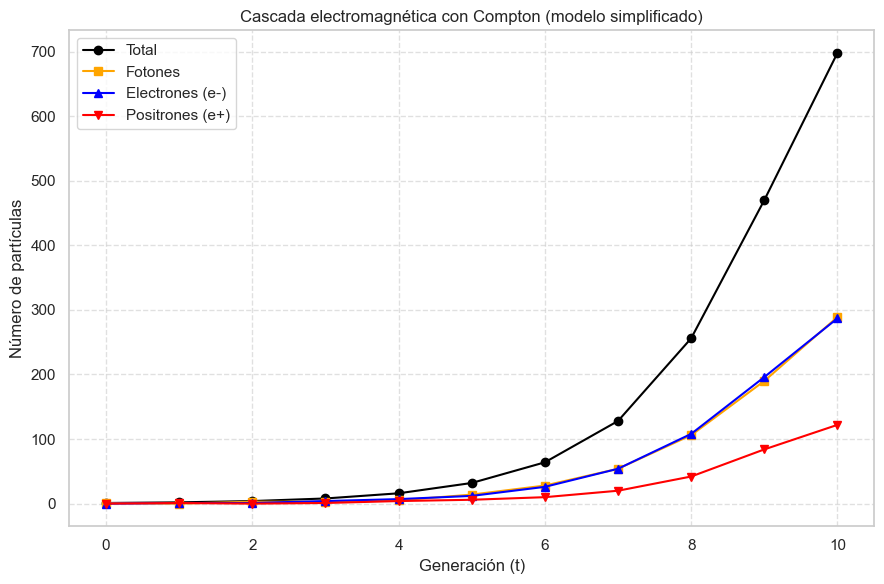

In [174]:
import random
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# Parámetros del modelo
# -------------------------
E0_MeV = 1000.0       # Energía inicial del fotón (MeV)
E_crit_MeV = 1.0      # Energía crítica (MeV)
max_generations = 10  # Número máximo de generaciones
P_ANNIHILATION = 0.3  # Probabilidad de aniquilación de e+
P_PAIR_PROD = 0.5     # Probabilidad de que un fotón haga par en vez de Compton

# -------------------------
# Función para dividir energía
# -------------------------
def random_split(E, frac_min=0.3, frac_max=0.7):
    frac = random.uniform(frac_min, frac_max)
    return E * frac, E * (1 - frac)

# -------------------------
# Simulación con Compton simplificado
# -------------------------
particles = [("gamma", E0_MeV)]
generations = []

for gen in range(max_generations + 1):
    # Contar partículas
    n_gamma = sum(1 for p, _ in particles if p == "gamma")
    n_e_minus = sum(1 for p, _ in particles if p == "e-")
    n_e_plus = sum(1 for p, _ in particles if p == "e+")
    
    generations.append({
        "Generación": gen,
        "Total": len(particles),
        "Fotones": n_gamma,
        "Electrones": n_e_minus,
        "Positrones": n_e_plus
    })
    
    # Nueva lista para la próxima generación
    new_particles = []
    for p_type, E in particles:
        if E < E_crit_MeV:
            continue
        
        if p_type == "gamma":
            # Decidir: par e+/e- o dispersión Compton
            if E > 2 * 0.511 and random.random() < P_PAIR_PROD:
                # Producción de par
                e1, e2 = random_split(E)
                new_particles.append(("e-", e1))
                new_particles.append(("e+", e2))
            else:
                # Efecto Compton simplificado: fotón dispersado + electrón recoil
                Eg, Ee = random_split(E)
                new_particles.append(("gamma", Eg))
                new_particles.append(("e-", Ee))
        
        elif p_type == "e-":
            # Radiación de frenado (bremsstrahlung): electrón + fotón
            Eg, Ee = random_split(E)
            new_particles.append(("gamma", Eg))
            new_particles.append(("e-", Ee))
        
        elif p_type == "e+":
            # Positrón: posible aniquilación
            if random.random() < P_ANNIHILATION:
                g1, g2 = random_split(E)
                new_particles.append(("gamma", g1))
                new_particles.append(("gamma", g2))
            else:
                # Si no aniquila, también radia como un electrón
                Eg, Ee = random_split(E)
                new_particles.append(("gamma", Eg))
                new_particles.append(("e+", Ee))
    
    particles = new_particles

# -------------------------
# DataFrame
# -------------------------
df = pd.DataFrame(generations)
print(df)

# -------------------------
# Gráficas
# -------------------------
plt.figure(figsize=(9,6))
plt.plot(df["Generación"], df["Total"], marker='o', label="Total", color="black")
plt.plot(df["Generación"], df["Fotones"], marker='s', label="Fotones", color="orange")
plt.plot(df["Generación"], df["Electrones"], marker='^', label="Electrones (e-)", color="blue")
plt.plot(df["Generación"], df["Positrones"], marker='v', label="Positrones (e+)", color="red")

plt.xlabel("Generación (t)")
plt.ylabel("Número de partículas")
plt.title("Cascada electromagnética con Compton (modelo simplificado)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


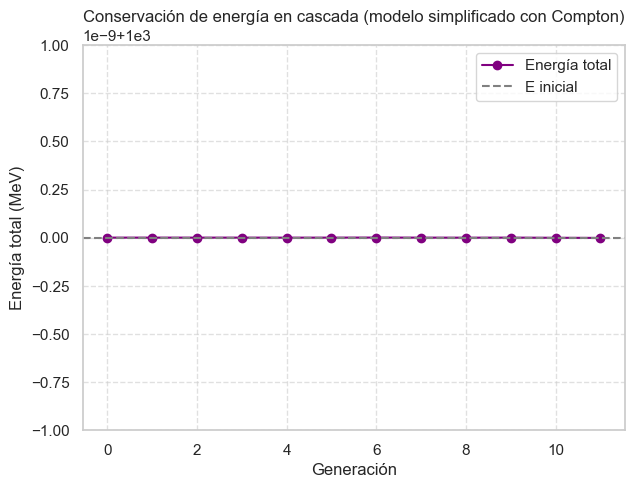

In [175]:
# -----------------------
# Parámetros
# -----------------------
ELECTRON_MASS = 0.511  # MeV
MAX_GENERATIONS = 12
ANNIHILATION_PROB = 0.3
PAIR_PROB_ABOVE_THRESHOLD = 0.5

# -----------------------
# Clase Partícula
# -----------------------
class Particle:
    def __init__(self, typ, energy):
        self.type = typ  # 'gamma', 'electron', 'positron'
        self.energy = float(energy)

# -----------------------
# División simple de energía
# -----------------------
def random_split(energy, frac_min=0.3, frac_max=0.7):
    frac = random.uniform(frac_min, frac_max)
    return (energy * frac, energy * (1 - frac))

# -----------------------
# Energía total
# -----------------------
def total_energy(particles):
    return sum(p.energy for p in particles)

# -----------------------
# Simulación con Compton simplificado
# -----------------------
def simulate_shower_simple(initial_energy, threshold):
    generation = 0
    particles = [Particle('gamma', initial_energy)]
    generation_counts = []
    generation_energies = []

    while particles and generation < MAX_GENERATIONS:
        new_particles = []

        for p in particles:
            if p.energy < threshold:
                new_particles.append(p)
                continue

            if p.type == 'gamma':
                # Pair production si hay energía suficiente
                if p.energy > 2.0 * ELECTRON_MASS and random.random() < PAIR_PROB_ABOVE_THRESHOLD:
                    e1, e2 = random_split(p.energy)
                    new_particles.append(Particle('electron', e1))
                    new_particles.append(Particle('positron', e2))
                else:
                    # Compton simplificado: fotón + electrón
                    E_gamma, E_electron = random_split(p.energy)
                    new_particles.append(Particle('gamma', E_gamma))
                    new_particles.append(Particle('electron', E_electron))

            elif p.type == 'electron':
                g, e = random_split(p.energy)
                new_particles.append(Particle('gamma', g))
                new_particles.append(Particle('electron', e))

            elif p.type == 'positron':
                if random.random() < ANNIHILATION_PROB:
                    g1, g2 = random_split(p.energy)
                    new_particles.append(Particle('gamma', g1))
                    new_particles.append(Particle('gamma', g2))
                else:
                    new_particles.append(Particle('positron', p.energy))

        generation_counts.append(len(new_particles))
        generation_energies.append(total_energy(new_particles))

        particles = new_particles
        generation += 1

    return generation_counts, generation_energies

# -----------------------
# Ejecutar simulación
# -----------------------
initial_energy = 1000.0  # MeV
threshold = 1.0          # MeV

counts, energies = simulate_shower_simple(initial_energy, threshold)

# -----------------------
# Graficar energía total
# -----------------------
gens = list(range(len(energies)))
plt.figure(figsize=(7,5))
plt.plot(gens, energies, marker='o', color="purple", label="Energía total")
plt.axhline(y=initial_energy, color='gray', linestyle='--', label="E inicial")
plt.xlabel("Generación")
plt.ylabel("Energía total (MeV)")
plt.title("Conservación de energía en cascada (modelo simplificado con Compton)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Análisis de resultados con el efecto Compton

La inclusión del **efecto Compton** en la simulación Monte Carlo de cascadas electromagnéticas introduce un incremento notable en el **número de partículas por generación**, ya que los fotones pueden transferir parte de su energía a electrones, los cuales a su vez alimentan el desarrollo de la cascada. Dicho de otra forma, hay más partículas por generación con Compton porque cada interacción Compton conserva el fotón original (dispersado) y además libera un electrón nuevo , en lugar de que el fotón desaparezca como en la producción de pares. Esto se observa en la gráfica de multiplicidad, donde el crecimiento es más acelerado que en el modelo con solo *Bethe–Heitler*.  

El efecto Compton se describe mediante la relación de dispersión:

$$
\lambda' - \lambda = \frac{h}{m_e c} (1 - \cos\theta),
$$

donde $\lambda$ es la longitud de onda inicial del fotón, $$\lambda$$ la longitud de onda dispersada, $$h$$ la constante de Planck, $$m_e$$ la masa del electrón y $\theta$ el ángulo de dispersión. Esta expresión muestra cómo el fotón pierde energía al interactuar con un electrón, generando partículas adicionales en la cascada.

A pesar de este incremento en la **multiplicidad de partículas**, la **energía total del sistema se conserva** de manera excelente: la curva se mantiene prácticamente plana alrededor de la energía inicial, con desviaciones del orden de 

$$
10^{-13} \, \text{MeV},
$$

que corresponden únicamente a errores numéricos de redondeo.  

En conclusión, la incorporación del proceso Compton no viola la conservación de la energía, sino que **redistribuye la misma entre un número mayor de partículas**, enriqueciendo el desarrollo de la cascada.
